In [1]:
import os
import time
import tqdm
import inceptionv3
import numpy as np
import tensorflow as tf

import utils
import defense

/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stanislas/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

In [2]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)

In [3]:
data_path = "./data"
output_path = "./finalresults"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
cleandata = np.load(os.path.join(data_path, "clean100data.npy"))
cleanlabel = np.load(os.path.join(data_path, "clean100label.npy"))
targets = np.load(os.path.join(data_path, "random_targets.npy"))

In [5]:
xs = tf.placeholder(tf.float32, (299, 299, 3))
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
label = tf.placeholder(tf.int32, ())
one_hot = tf.expand_dims(tf.one_hot(label, 1000), axis=0)

lam = 1e-6
epsilon = 0.05
ENSEMBLE_SIZE = 30
max_steps = 1000
LR = 0.1

xs_def = tf.expand_dims(defense.tftensorGD(xs), axis=0)
logits, preds = inceptionv3.model(sess, xs_def)
l2_loss = tf.sqrt(2 * tf.nn.l2_loss(l2_x - l2_orig) / (299 * 299 * 3))

xs_ens = tf.stack([defense.tftensorGD(xs) for _ in range(ENSEMBLE_SIZE)], axis=0)
logits_ens, preds_ens = inceptionv3.model(sess, xs_ens)

labels_ens = tf.tile(one_hot, (logits_ens.shape[0], 1))
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_ens, labels=labels_ens))
loss_ens = xent + lam * tf.maximum(l2_loss - epsilon, 0)
grad_ens, = tf.gradients(loss_ens, xs)
probs_ens = tf.nn.softmax(logits_ens)


INFO:tensorflow:Scale of 0 disables regularizer.






Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/stanislas/Advanced-Gradient-Obfuscating/data/inception_v3.ckpt
INFO:tensorflow:Scale of 0 disables regularizer.


# Without Defense

In [ ]:
adv = np.copy(cleandata)

start = time.time()
for index in range(cleandata.shape[0]):
    
    EOT_adv = np.copy(adv[index])
    
    for i in tqdm.notebook.tqdm(range(max_steps)):
        p, l2 = sess.run([preds, l2_loss], {xs: EOT_adv, l2_x: EOT_adv, l2_orig: cleandata[index]})
        if p == targets[index] and l2 < epsilon:
            print("Found targeted AE. Iter: {}. L2: {}.".format(i, l2))
            break
        elif l2 > epsilon:
            print("Can't find targeted AE under l2-norm 0.05.")
            break
        
        g_ens, p_ens = sess.run([grad_ens, preds_ens], {xs: adv[index], label: targets[index]})
        EOT_adv -= LR * g_ens
        EOT_adv = np.clip(EOT_adv, 0, 1)
        
    adv[index] = EOT_adv

# Adopt the EOT over RDDfense (Targeted)

In [7]:
adv = np.copy(cleandata)

start = time.time()
for index in range(cleandata.shape[0]):
    
    EOT_adv = np.copy(adv[index])
    
    for i in tqdm.notebook.tqdm(range(max_steps)):
        adv_def = defense.defend_FD_sig(EOT_adv)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: EOT_adv, l2_orig: cleandata[index]})
        if p == targets[index] and l2 < epsilon:
            print("Found targeted AE. Iter: {}. L2: {}.".format(i, l2))
            break
        elif l2 > epsilon:
            print("Can't find targeted AE under l2-norm 0.05.")
            break
        
        g_ens, p_ens = sess.run([grad_ens, preds_ens], {xs: adv[index], label: targets[index]})
        EOT_adv -= LR * g_ens
        EOT_adv = np.clip(EOT_adv, 0, 1)
        
    adv[index] = EOT_adv

Can't find targeted AE under l2-norm 0.05.


KeyboardInterrupt: 

# Adopt the EOT over RDDfense (Untargeted)

In [8]:
max_steps = 1000
LR = 0.1
adv = np.copy(cleandata)

start = time.time()
for index in range(cleandata.shape[0]):
    
    EOT_adv = np.copy(adv[index])
    
    for i in tqdm.notebook.tqdm(range(max_steps)):
        adv_def = defense.defend_FD_sig(EOT_adv)
        p, l2 = sess.run([preds, l2_loss],{xs: adv_def, l2_x: EOT_adv, l2_orig: cleandata[index]})
        if p != cleanlabel[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break
        
        g_ens, p_ens = sess.run([grad_ens, preds_ens], {xs: adv[index], label: targets[index]})
        EOT_adv -= LR * g_ens
        EOT_adv = np.clip(EOT_adv, 0, 1)
        
    adv[index] = EOT_adv

Found AE. Iter: 4. L2: 0.005909300874918699.



Can't find AE under l2-norm 0.05.


Found AE. Iter: 8. L2: 0.0042489068582654.


Found AE. Iter: 3. L2: 0.0036394642665982246.


Found AE. Iter: 3. L2: 0.003507492830976844.


Found AE. Iter: 2. L2: 0.002140712458640337.


Found AE. Iter: 2. L2: 0.0012342778500169516.


Found AE. Iter: 48. L2: 0.02776772528886795.


Found AE. Iter: 1. L2: 0.0025950351264327765.


Found AE. Iter: 61. L2: 0.04933381825685501.


Found AE. Iter: 3. L2: 0.002634381642565131.


Found AE. Iter: 4. L2: 0.006718010641634464.


Found AE. Iter: 5. L2: 0.003189956536516547.


Found AE. Iter: 11. L2: 0.010538422502577305.



Found AE. Iter: 1. L2: 0.0009718741639517248.


Can't find AE under l2-norm 0.05.


Found AE. Iter: 7. L2: 0.00886074360460043.


Found AE. Iter: 2. L2: 0.002993981586769223.


Found AE. Iter: 3. L2: 0.007471349555999041.


Found AE. Iter: 7. L2: 0.0030122860334813595.


Found AE. Iter: 4. L2: 0.0016808946384117007.


Found AE. Iter: 11. L2: 0.008518989197909832.


Found AE. Iter: 21. L2: 0.017534684389829636.


Found AE. Iter: 1. L2: 0.0005513696232810616.


Found AE. Iter: 2. L2: 0.0022700796835124493.


Found AE. Iter: 17. L2: 0.006879265885800123.


Found AE. Iter: 3. L2: 0.0033524653408676386.


Found AE. Iter: 19. L2: 0.01694522425532341.


Found AE. Iter: 69. L2: 0.0354270413517952.


Found AE. Iter: 3. L2: 0.001479442580603063.


Found AE. Iter: 15. L2: 0.00974921602755785.


Found AE. Iter: 6. L2: 0.0049639251083135605.


Found AE. Iter: 1. L2: 0.0021411252673715353.


Found AE. Iter: 5. L2: 0.01033684704452753.


Found AE. Iter: 2. L2: 0.004496621899306774.


Found AE. Iter: 77. L2: 0.03669407591223717.


Can't find AE under l2-norm 0.05.


Found AE. Iter: 2. L2: 0.004342837259173393.


Found AE. Iter: 13. L2: 0.0070775034837424755.


Found AE. Iter: 0. L2: 0.0.


Found AE. Iter: 19. L2: 0.009218445979058743.


Found AE. Iter: 99. L2: 0.029629601165652275.


Found AE. Iter: 3. L2: 0.0030337506905198097.


Found AE. Iter: 5. L2: 0.004686800297349691.


Found AE. Iter: 17. L2: 0.01812531240284443.


Found AE. Iter: 0. L2: 0.0.


Found AE. Iter: 12. L2: 0.007098676636815071.


Found AE. Iter: 0. L2: 0.0.


Found AE. Iter: 8. L2: 0.005347458645701408.


Found AE. Iter: 4. L2: 0.0020011712331324816.


Found AE. Iter: 0. L2: 0.0.


Found AE. Iter: 4. L2: 0.0023903208784759045.


Found AE. Iter: 3. L2: 0.004778875969350338.


Found AE. Iter: 5. L2: 0.003540951758623123.


Found AE. Iter: 9. L2: 0.006849322002381086.


Found AE. Iter: 37. L2: 0.012015556916594505.


Found AE. Iter: 1. L2: 0.0035569285973906517.


Found AE. Iter: 5. L2: 0.0034164951648563147.


Found AE. Iter: 2. L2: 0.004963983781635761.


Found AE. Iter: 3. L2: 0.009328554384410381.


Can't find AE under l2-norm 0.05.


Found AE. Iter: 1. L2: 0.0015400223201140761.


Found AE. Iter: 1. L2: 0.0013884209329262376.


Found AE. Iter: 1. L2: 0.0014334196457639337.


Found AE. Iter: 11. L2: 0.008871111087501049.


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/stanislas/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/stanislas/anaconda3/lib/python3.7/site-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/home/stanislas/anaconda3/lib/python3.7/site-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/home/stanislas/anaconda3/lib/python3.7/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/home/stanislas/anaconda3/lib/python3.7/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/home/stanislas/anaconda3/lib/python3.7/_weakrefset.py", line 119, in update
    for element in other:
  File "/home/stanislas/anaconda3/lib/python3.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Found AE. Iter: 23. L2: 0.01791609264910221.


Found AE. Iter: 13. L2: 0.01675550267100334.


Found AE. Iter: 11. L2: 0.006628726609051228.


Found AE. Iter: 8. L2: 0.004932932090014219.


Found AE. Iter: 56. L2: 0.0329548642039299.


Found AE. Iter: 0. L2: 0.0.


Can't find AE under l2-norm 0.05.


Found AE. Iter: 4. L2: 0.0032122849952429533.


Found AE. Iter: 3. L2: 0.0020479841623455286.


Found AE. Iter: 2. L2: 0.002962078433483839.


Found AE. Iter: 3. L2: 0.004125276114791632.


Found AE. Iter: 6. L2: 0.006388619542121887.


Can't find AE under l2-norm 0.05.


Found AE. Iter: 4. L2: 0.004476167727261782.


Can't find AE under l2-norm 0.05.


Found AE. Iter: 3. L2: 0.006326628383249044.


Found AE. Iter: 0. L2: 0.0.


Can't find AE under l2-norm 0.05.


KeyboardInterrupt: 

# Adopt the EOT over random crop

In [9]:
#将防御机制导入进session
x_single = tf.placeholder(tf.float32, (299, 299, 3))
TARGET = 999

session_xs = randomizing_crop(x_single)
session_logits, session_preds = inceptionv3.model(sess, session_xs)
session_l2_x = tf.placeholder(tf.float32, (299, 299, 3))
session_l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
session_normalized_l2_loss = tf.nn.l2_loss(session_l2_orig - session_l2_x) / tf.nn.l2_loss(session_l2_orig)
session_probs = tf.reduce_mean(tf.nn.softmax(session_logits), axis=0, keepdims=True)

Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Scale of 0 disables regularizer.


In [10]:
#详细参见底层，crop_size=90, ensemble_size=30
ENSEMBLE_SIZE = 30 # larger sample size -> better gradient estimate

cropped_xs = defend_crop(x_single,ensemble_size=ENSEMBLE_SIZE)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_xs)
cropped_probs = tf.reduce_mean(tf.nn.softmax(cropped_logits), axis=0, keepdims=True)

cropped_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (cropped_logits.shape[0], 1))
stacked_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=cropped_logits, labels=cropped_labels)
cropped_loss = tf.reduce_mean(stacked_loss)
cropped_grad, = tf.gradients(cropped_loss, x_single)

INFO:tensorflow:Scale of 0 disables regularizer.


In [7]:
# randomcrop--卡列尼的EOT攻击crop实验

AccList_CROP_EOT = []
SuccessList_CROP_EOT = []


LR = 0.1
newadv = np.copy(cleandata)
start = time.time()

for index in tqdm.tqdm(range(newadv.shape[0])):
    
    EOT_adv = np.copy(newadv[index])


    for i in range(50):
        
        p_E,l2_E,full_loss,mean_loss = sess.run([session_preds,session_normalized_l2_loss,stacked_loss,cropped_loss],{x_single: EOT_adv, session_l2_x: EOT_adv, session_l2_orig: cleandata[index]})
        Accuracy_E = np.mean((p_E == cleanlabel[index]).astype(int))
        SuccessRate_E = np.mean((p_E == TARGET).astype(int))
        AccList_CROP_EOT.append(Accuracy_E)
        SuccessList_CROP_EOT.append(SuccessRate_E)
        
        EOT_g, EOT_p= sess.run([cropped_grad, cropped_preds], {x_single: EOT_adv})
        EOT_adv -= LR * EOT_g
        # project
        EOT_adv = np.clip(EOT_adv, 0, 1)  
        
    newadv[index] = EOT_adv
    
AccList_CROP_EOT = np.mean(np.asarray(AccList_CROP_EOT).reshape(-1,50),0)
SuccessList_CROP_EOT = np.mean(np.asarray(SuccessList_CROP_EOT).reshape(-1,50),0)

end = time.time()
print('total time: ' + str(end - start))

100%|██████████| 100/100 [20:32<00:00, 12.33s/it]

total time: 1232.6994044780731


In [17]:
np.save(path+'/CROP_EOT_Acc.npy', AccList_CROP_EOT)
np.save(path+'/CROP_EOT_Suc.npy', SuccessList_CROP_EOT)

# Adopt EOT over RandCrop + FD

In [11]:
# randomcrop + FD

AccList_CROP_FD_EOT = []
SuccessList_CROP_FD_EOT = []


LR = 0.1
newadv = np.copy(cleandata)
start = time.time()

for index in tqdm.tqdm(range(newadv.shape[0])):
    
    EOT_adv = np.copy(newadv[index])


    for i in range(50):
        GRD_adv = defend_FD_sig(EOT_adv) 
        p_E,l2_E,full_loss,mean_loss = sess.run([session_preds,session_normalized_l2_loss,stacked_loss,cropped_loss],{x_single: GRD_adv, session_l2_x: EOT_adv, session_l2_orig: cleandata[index]})
        Accuracy_E = np.mean((p_E == cleanlabel[index]).astype(int))
        SuccessRate_E = np.mean((p_E == TARGET).astype(int))
        AccList_CROP_FD_EOT.append(Accuracy_E)
        SuccessList_CROP_FD_EOT.append(SuccessRate_E)
        
        EOT_g, EOT_p= sess.run([cropped_grad, cropped_preds], {x_single: GRD_adv})
        EOT_adv -= LR * EOT_g
        # project
        EOT_adv = np.clip(EOT_adv, 0, 1)  
        
    newadv[index] = EOT_adv
    
AccList_CROP_FD_EOT = np.mean(np.asarray(AccList_CROP_FD_EOT).reshape(-1,50),0)
SuccessList_CROP_FD_EOT = np.mean(np.asarray(SuccessList_CROP_FD_EOT).reshape(-1,50),0)

end = time.time()
print('total time: ' + str(end - start))

100%|██████████| 100/100 [43:22<00:00, 26.02s/it]

total time: 2602.4250149726868


In [12]:
np.save(path+'/CROP_FD_EOT_Acc.npy', AccList_CROP_FD_EOT)
np.save(path+'/CROP_FD_EOT_Suc.npy', SuccessList_CROP_FD_EOT)

# Adopt EOT over Randomization

In [12]:
#将防御机制导入进session
x_single = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x_single, axis=0)
TARGET = 999

session_xs = defend_randomization(x_expanded)
session_logits, session_preds = inceptionv3.model(sess, session_xs)
session_l2_x = tf.placeholder(tf.float32, (299, 299, 3))
session_l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
session_normalized_l2_loss = tf.nn.l2_loss(session_l2_orig - session_l2_x) / tf.nn.l2_loss(session_l2_orig)
session_probs = tf.reduce_mean(tf.nn.softmax(session_logits), axis=0, keepdims=True)

INFO:tensorflow:Scale of 0 disables regularizer.


In [13]:
ENSEMBLE_SIZE = 30 # larger sample size -> better gradient estimate

In [14]:
ensemble_xs = tf.squeeze(tf.stack([defend_randomization(x_expanded) for _ in range(ENSEMBLE_SIZE)], axis=0))
ensemble_logits, ensemble_preds = inceptionv3.model(sess, ensemble_xs)
ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (ensemble_logits.shape[0], 1))
stacked_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels)
ensemble_loss = tf.reduce_mean(stacked_loss)
ensemble_grad, = tf.gradients(ensemble_loss, x_single)
ensemble_probs = tf.nn.softmax(ensemble_logits)

INFO:tensorflow:Scale of 0 disables regularizer.


In [12]:
# randomization input

AccList_RAND_EOT = []
SuccessList_RAND_EOT = []

LR = 0.1
newadv = np.copy(cleandata)
start = time.time()

trainround = 50

for index in tqdm.tqdm(range(newadv.shape[0])):
    
    EOT_adv = np.copy(newadv[index])

    for i in range(trainround):

        p_E,l2_E,full_loss,mean_loss = sess.run([session_preds,session_normalized_l2_loss,stacked_loss,ensemble_loss],{x_single: EOT_adv, session_l2_x: EOT_adv, session_l2_orig: cleandata[index]})
        Accuracy_E = np.mean((p_E == cleanlabel[index]).astype(int))
        SuccessRate_E = np.mean((p_E == TARGET).astype(int))
        AccList_RAND_EOT.append(Accuracy_E)
        SuccessList_RAND_EOT.append(SuccessRate_E)
           
        EOT_g, EOT_p= sess.run([ensemble_grad, ensemble_preds], {x_single: EOT_adv}) #此处使用的输入是无GD保护的图像
        EOT_adv -= LR * EOT_g
        EOT_adv = np.clip(EOT_adv, 0, 1)

        
    newadv[index] = EOT_adv
    
AccList_RAND_EOT = np.mean(np.asarray(AccList_RAND_EOT).reshape(-1,trainround),0)
SuccessList_RAND_EOT = np.mean(np.asarray(SuccessList_RAND_EOT).reshape(-1,trainround),0)


end = time.time()
print('total time: ' + str(end - start))

100%|██████████| 100/100 [20:42<00:00, 12.42s/it]

total time: 1242.3294789791107


In [13]:
np.save(path+'/RAND_EOT_Acc.npy', AccList_RAND_EOT)
np.save(path+'/RAND_EOT_Suc.npy', SuccessList_RAND_EOT)

# Adopt EOT over Randomization + FD

In [15]:
# randomization input

AccList_RAND_FD_EOT = []
L2List_RAND_FD_EOT = []
LinfList_RAND_FD_EOT = []
SuccessList_RAND_FD_EOT = []

LR = 0.1
newadv = np.copy(cleandata)
start = time.time()

trainround = 50

for index in tqdm.tqdm(range(newadv.shape[0])):
    
    EOT_adv = np.copy(newadv[index])

    for i in range(trainround):
    
        GRD_adv = defend_FD_sig(EOT_adv) 
        p_E,l2_E,full_loss,mean_loss = sess.run([session_preds,session_normalized_l2_loss,stacked_loss,ensemble_loss],{x_single: GRD_adv, session_l2_x: EOT_adv, session_l2_orig: cleandata[index]})
        Accuracy_E = np.mean((p_E == cleanlabel[index]).astype(int))
        SuccessRate_E = np.mean((p_E == TARGET).astype(int))
        AccList_RAND_FD_EOT.append(Accuracy_E)
        
        L2 = l2_distortion(EOT_adv, cleandata[index])
        Linf = linf_distortion(EOT_adv, cleandata[index])
        
        L2List_RAND_FD_EOT.append(L2)
        LinfList_RAND_FD_EOT.append(Linf)
        SuccessList_RAND_FD_EOT.append(SuccessRate_E)
           
        EOT_g, EOT_p= sess.run([ensemble_grad, ensemble_preds], {x_single: GRD_adv}) #此处使用的输入是无GD保护的图像
        EOT_adv -= LR * EOT_g
        EOT_adv = np.clip(EOT_adv, 0, 1)

        
    newadv[index] = EOT_adv
    
AccList_RAND_FD_EOT = np.mean(np.asarray(AccList_RAND_FD_EOT).reshape(-1,trainround),0)
SuccessList_RAND_FD_EOT = np.mean(np.asarray(SuccessList_RAND_FD_EOT).reshape(-1,trainround),0)
L2List_RAND_FD_EOT = np.mean(np.asarray(L2List_RAND_FD_EOT).reshape(-1,trainround),0)
LinfList_RAND_FD_EOT = np.mean(np.asarray(LinfList_RAND_FD_EOT).reshape(-1,trainround),0)

end = time.time()
print('total time: ' + str(end - start))

100%|██████████| 100/100 [46:45<00:00, 28.06s/it]

total time: 2805.7080085277557


In [16]:
np.save(path+'/RAND_FD_EOT_Acc.npy', AccList_RAND_FD_EOT)
np.save(path+'/RAND_FD_EOT_Suc.npy', SuccessList_RAND_FD_EOT)
np.save(path+'/RAND_FD_EOT_L2.npy', L2List_RAND_FD_EOT)
np.save(path+'/RAND_FD_EOT_Linf.npy', LinfList_RAND_FD_EOT)

In [3]:
path = 'finalresults'
AccList = np.load(path+'/NoDAcc.npy')
SuccessList = np.load(path+'/NoDSuc.npy')
L2List = np.load(path+'/NoDL2.npy')
LinfList = np.load(path+'/NoDLinf.npy')

AccList_NEW_EOT = np.load(path+'/RDD_EOT_Acc.npy')
SuccessList_NEW_EOT = np.load(path+'/RDD_EOT_Suc.npy')
L2List_NEW_EOT = np.load(path+'/RDD_EOT_L2.npy')
LinfList_NEW_EOT = np.load(path+'/RDD_EOT_Linf.npy')

AccList_CROP_EOT = np.load(path+'/CROP_EOT_Acc.npy')
SuccessList_CROP_EOT = np.load(path+'/CROP_EOT_Suc.npy')

AccList_RAND_EOT = np.load(path+'/RAND_EOT_Acc.npy')
SuccessList_RAND_EOT = np.load(path+'/RAND_EOT_Suc.npy')

AccList_CROP_FD_EOT = np.load(path+'/CROP_FD_EOT_Acc.npy')
SuccessList_CROP_FD_EOT = np.load(path+'/CROP_FD_EOT_Suc.npy')

AccList_RAND_FD_EOT = np.load(path+'/RAND_FD_EOT_Acc.npy')
SuccessList_RAND_FD_EOT = np.load(path+'/RAND_FD_EOT_Suc.npy')
L2List_RAND_FD_EOT = np.load(path+'/RAND_FD_EOT_L2.npy')
LinfList_RAND_FD_EOT = np.load(path+'/RAND_FD_EOT_Linf.npy')

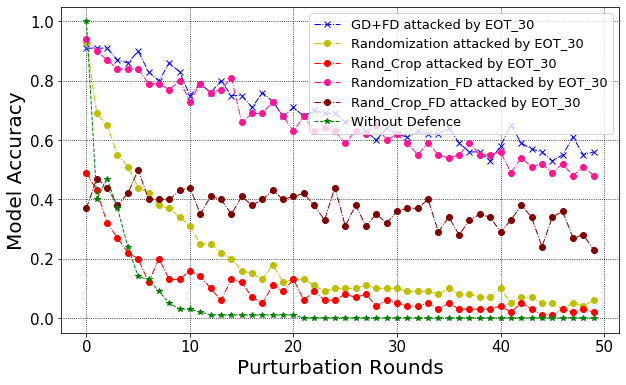

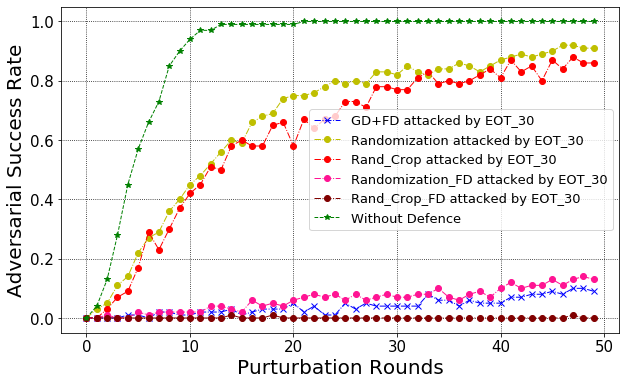

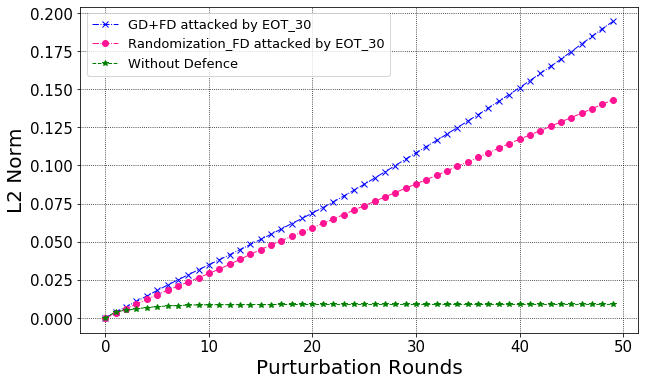

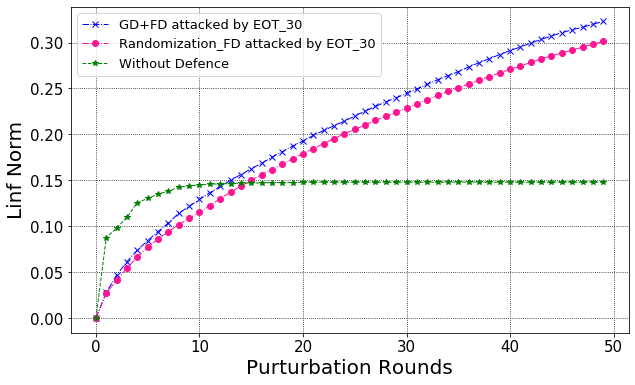

In [5]:
totalrounds = 50
plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),AccList_NEW_EOT, color="b",label='GD+FD attacked by EOT_30', linestyle="-.", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_RAND_EOT, color="y",label='Randomization attacked by EOT_30', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_CROP_EOT, color="r",label='Rand_Crop attacked by EOT_30', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_RAND_FD_EOT, color="deeppink",label='Randomization_FD attacked by EOT_30', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_CROP_FD_EOT, color="maroon",label='Rand_Crop_FD attacked by EOT_30', linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList, color="g", label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Model Accuracy",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/EOT_ModelAcc.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),SuccessList_NEW_EOT, color="b", label='GD+FD attacked by EOT_30',linestyle="-.", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_RAND_EOT, color="y", label='Randomization attacked by EOT_30',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_CROP_EOT, color="r", label='Rand_Crop attacked by EOT_30',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_RAND_FD_EOT, color="deeppink", label='Randomization_FD attacked by EOT_30',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_CROP_FD_EOT, color="maroon", label='Rand_Crop_FD attacked by EOT_30',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList, color="g", label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Adversarial Success Rate",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/EOT_AtkSucc.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),L2List_NEW_EOT, color="b", label='GD+FD attacked by EOT_30',linestyle="-.", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),L2List_RAND_FD_EOT, color="deeppink", label='Randomization_FD attacked by EOT_30',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),L2List, color="g",  label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("L2 Norm",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/EOT_AEL2.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.arange(totalrounds),LinfList_NEW_EOT, color="b", label='GD+FD attacked by EOT_30',linestyle="-.", marker="x", linewidth=1.0)
plt.plot(np.arange(totalrounds),LinfList_RAND_FD_EOT, color="deeppink", label='Randomization_FD attacked by EOT_30',linestyle="-.", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),LinfList, color="g",  label='Without Defence',linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Linf Norm",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/EOT_AELinf.png',bbox_inches='tight')
plt.show()